<img src='https://wallpaperaccess.com/full/471490.jpg' />

# Greek Hedging

W tym notebooku zaprezentujemy:
* Jaka jest intuicja za greckimi parametrami?
* Co stoi za zmianą cen instrumentu pochodnego?
* Jak możemy użyć tej wiedzy do zabezpieczenia pozycji?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import scipy.stats as sc
from scipy.stats import norm
from IPython.core.debugger import Pdb
import mibian
import yfinance as yf
from tqdm import tqdm
plt.style.use('default')

%matplotlib notebook

### Geometryczny ruch Browna

Jako model cen akcji przyjmujemy GBM, poniżej przykładowa funkcja generująca wybraną liczbę trajektorii przy zadanych parametrach

In [2]:
def gbm(S0: float, r: float, sigma: float, T: float, time_steps: int, n_paths: int, 
        random_generator = sc.norm(0, 1)):
    """
    Generate Geometric Brownian Motion paths
    :param S0: float, starting price
    :param r: float, risk free rate
    :param sigma: float, volatility
    :param T: float, time horizon
    :param time_steps: int, how many subintervals include from 0 to T
    :param n_paths: int, how many paths to simulate
    :param random_generator: distribution family from which to draw random increments
    :return: paths: ndarray, simulated paths
    """
    
    dt = float(T) / time_steps
    paths = np.zeros((time_steps + 1, n_paths), np.float64)
    paths[0] = S0
    for t in range(1, time_steps + 1):
        rand = random_generator.rvs(size = n_paths)
        paths[t] = paths[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt +
                                         sigma * np.sqrt(dt) * rand)
    return paths

def run_animation(t: np.array, stochastic_process: np.ndarray, title: str, tempo:float = 1):
    """
    Animate a trajectory
    :param t: np.array, x-axis (time)
    :param stochastic_process: np.ndarray, trajectories of a stochastic process over 't'
    :param title: str, plot title
    :param tempo: int, factor to control animation speed
    """
    X = stochastic_process.T
    N = X.shape[1] - 1
    m = X.shape[0]
    
    fig = plt.figure()
    ax = plt.axes(xlim=(t.min(), t.max()), ylim=(X.min() - 0.5, X.max() + 0.5))
    
    # lists to store x and y axis points 
    xdata = []
    ydata = []
    lines = []
    for l in range(m):
        line, = ax.plot([], [], lw=2)#, color='#0492C2')
        lines.append(line)
        ydata.append([])
        
    ax.set_ylabel('y')
    ax.set_xlabel('t')
    ax.set_title(title)
    ax.grid(True, which='major', linestyle='--', color='black', alpha=0.4)
    
    # initialization function 
    def init(): 
        # creating an empty plot/frame 
        for line in lines:
            line.set_data([], []) 
        return lines
    
    # animation function 
    def animate(i):
        # appending new points to x, y axes points list 
        xdata.append(t[i]) 
        for ind, line in enumerate(lines):
            ydata[ind].append(X[ind][i]) 
            line.set_data(xdata, ydata[ind]) 
        return lines,

    return animation.FuncAnimation(fig, animate, init_func=init, frames=N, interval=tempo*1000/N, repeat = False, blit=True)

<IPython.core.display.Javascript object>


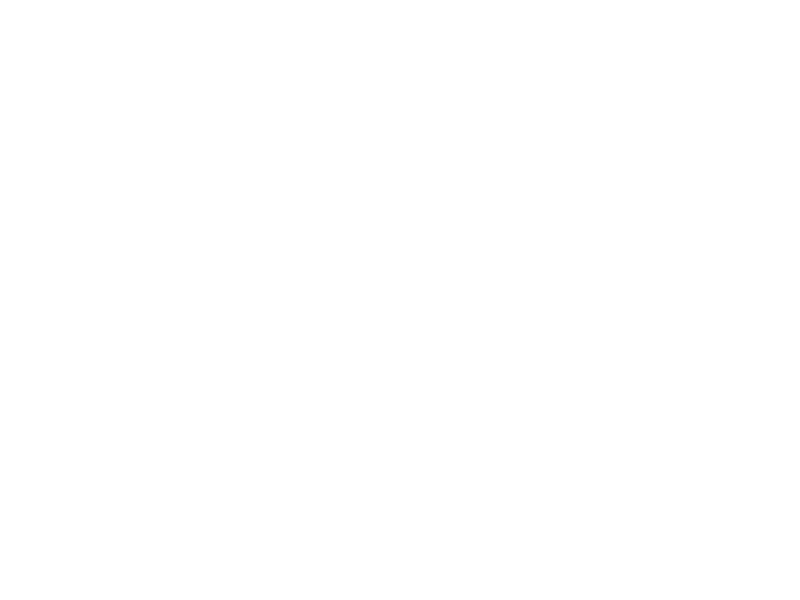

In [3]:
%matplotlib notebook
N = 252
n = 1
St = gbm(S0 = 100, r = 0.01, sigma = 0.3, T = 1, time_steps=N, n_paths = 3)
t = np.linspace(0, 1, N)
run_animation(t, St, 'Stock price')

### Wycena opcji

Do wyceny posłuzymy się biblioteką `mibian` (<a href="https://github.com/neilsmurphy/MibianLib">GitHub: MibianLib</a>).

Zawiera gotowe algorytmy waluacyjne dla waniliowych opcji europejskich. Dostaniemy z niej ceny i wartości greckich parametrów dla opcji call i put 

In [4]:
S0 = 150.0
K = 150.0
rfr = 1 # in pct
T = 365# in days
sigma = 40 # in pct
option = mibian.BS([S0, K, rfr, T], volatility = sigma)


print(f"""
Call 
-----
Price: {option.callPrice:.4f}
Delta: {option.callDelta:.4f}
Gamma: {option.gamma:.4f}
Theta: {option.callTheta:.4f}
Vega:  {option.vega:.4f}
Rho:   {option.callRho:.4f}
""")


Call 
-----
Price: 24.4132
Delta: 0.5890
Gamma: 0.0065
Theta: -0.0337
Vega:  0.5835
Rho:   0.6394



## Black-Scholes PDE
### Czyli co wpływa na wartość <s>opcji</s> instrumentu pochodnego?

Rozważymy cenę akcji $S_t$ o dynamice zadanej geometrycznym ruchem Browna, oraz instrumentu pochodnego $V_t$ używającym $S_t$ jako instrument bazowy.

Teoria Blacka-Scholesa mówi, że przy założeniach braku arbitrażu i zupełności rynku dynamika dowolnej derywaty spełnia cząstkowe równanie różniczkowe:

$$dV = \sigma S \frac{\partial V}{\partial S}dW + \bigg( \mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt$$.

Widzimy dwa źródła dynamiki ceny: deterministyczne ($dt$), oraz losowe ($dW$).

W szczególności, dla instrumentu bazowego:

$$ dS = \mu S dt + \sigma S dW $$

## $\Delta$ hedging

Rozpatrzmy wartość portfel $\Pi$, złożony z derywaty $V$, oraz $x$ jednostek instrumentu bazowego $S$. Na zmiany wartości portfela wpływają dwa składniki:

$$ d\Pi = dV - x dS$$.

Rozpisując $dV$ i $dS$:
$$ d\Pi =  \sigma S \frac{\partial V}{\partial S}dW + \bigg( \mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt - x \bigg(\mu S dt + \sigma S dW  \bigg) $$



$$ d\Pi = \bigg(\mu S \frac{\partial V}{\partial S} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} -x\mu S \bigg)dt + \bigg(\sigma S \frac{\partial V}{\partial S} - x \sigma S \bigg)dW $$

$$ d\Pi = \bigg(\mu S \bigg(\frac{\partial V}{\partial S} - x \bigg)+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt + \sigma S \bigg(\frac{\partial V}{\partial S} - x \bigg)dW $$

**Q: Czy istnieje jakaś "specjalna" wartość $x$?**

**Q: Co się przy niej dzieje z wartością portfela $\Pi$?**

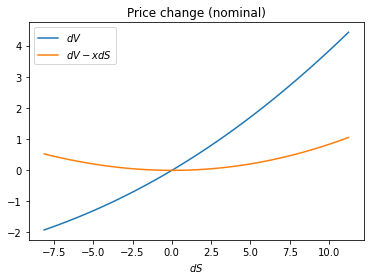

In [5]:
%matplotlib inline

# Numeric params setup
MC = 10000
dt = 5/365

# Market/Option params setup
r = 0.05
sig = 0.3
T = 1
S0 = 70
K = 90
option = mibian.BS([S0, K, r*100, T*365], volatility = sig*100)

# Compute delta and price
delta = option.callDelta
V_0 = option.callPrice

# Simulate 1 day stock trajectory
S_1D = gbm(S0, r, sig, dt, 1, MC)[-1]

# Make an array of likely stock prices, based on min-max of the simulation.
# Compute option prices on that array.
S_1D = np.linspace(S_1D.min(), S_1D.max(), 100)
V_1D = np.array([mibian.BS([S, K, r*100, 364], volatility = sig*100).callPrice for S in S_1D])

# Compute price changes
DV_1D = (V_1D - V_0)
DP_1D = (V_1D - delta*S_1D) - (V_0 - delta*S0)

# Plot changes of pure option vs portfolio
plt.plot(S_1D - S0, DV_1D, label = '$dV$')
plt.plot(S_1D - S0, DP_1D, label = '$dV - xdS$')
plt.xlabel('$dS$')
plt.title('Price change (nominal)')
_ = plt.legend()

<div class="alert alert-block alert-info">
<b>Co tak właściwie się dzieje?</b>
    
$$ d\Pi = \bigg(\mu S \bigg(\frac{\partial V}{\partial S} - x \bigg)+ \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt + \sigma S \bigg(\frac{\partial V}{\partial S} - x \bigg)dW $$

Dobierając $x = \frac{\partial V}{\partial S}$ dostajemy dynamikę portfela:

$$ d\Pi = \bigg(\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2} + \frac{\partial V}{\partial t} \bigg)dt $$.   
</div>


A pisząc to samo po grecku:

Dobierając $x = \Delta$ dostajemy dynamikę portfela:

$$ d\Pi = \bigg(\frac{1}{2}\sigma^2 S^2 \Gamma + \Theta \bigg)dt $$

<IPython.core.display.Javascript object>


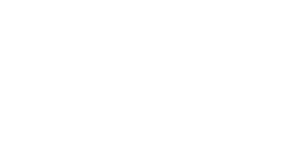

In [6]:
%matplotlib notebook

@np.vectorize
def price_surface(S_, t_):
    return mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice

@np.vectorize
def price_surface_delta_hedged(S_, t_):
    option = mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    return option - (delta*S_ - (delta*S0)*np.exp(r*t_))


S_lattice = np.linspace(S_1D.min(), S_1D.max(), 20)
t_lattice = np.linspace(0, dt, 20)

S, t = np.meshgrid(S_lattice, t_lattice)
V = price_surface(S, t)
Vh = price_surface_delta_hedged(S, t)

zmin, zmax = min(Vh.min(),V.min()) - V_0, max(Vh.max(), V.max()) - V_0

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121,projection='3d')

ax1.plot_surface(S - S0, t, V - V_0, cmap='magma')
ax1.set_xlabel('$S_t$')
ax1.set_ylabel('$T$')
ax1.set_zlabel('Value change')
ax1.set_title('Unhedged portfolio')
ax1.set_zlim(zmin, zmax)

ax2 = fig.add_subplot(122,projection='3d')

ax2.plot_surface(S - S0, t, Vh - V_0, cmap='magma')
ax2.set_xlabel('$S_t$')
ax2.set_ylabel('$T$')
ax2.set_zlabel('Value change')
ax2.set_title('Hedged portfolio')
ax2.set_zlim(zmin, zmax)

plt.tight_layout()

## $\Delta-\Gamma$ hedging

Gammą instrumentu $V_t$ nazywamy $\Gamma := \frac{\partial^2 V}{\partial S^2}$. Jeżeli ta wartość również wyniesie zero, to portfel nazwiemy delta-gamma-neutralnym.

$$ d\Pi = \Big(\Theta +  \frac{1}{2}\sigma^2S^2\Gamma \Big)dt $$ 

$$ d\Pi = \Big(\Theta + 0 \Big)dt $$ 

Aby uzyskać portfel $\Delta$ neutralny musieliśmy posłużyć się innym, dodatkowym instrumentem finansowym. 
Okazuje się, że aby można uzyskać portfel jednocześnie $\Delta$ neutralny i $\Gamma$ neutralny ($\Delta-\Gamma$ neutralny), ale będziemy potrzebować do tego dwóch instrumentów.

Zajmiemy więc pozycję $x$ w akcji $S$, pozycję $y$ w opcji $C$, oraz sfinalizujemy to pozycją $z$ w obligacjach taką, żeby cały hedge był bezkosztowy:

$$ \Pi = V + x S + y C + z$$

$$ \Delta_{\Pi} = \Delta_{V} + x\Delta_{S} + y\Delta_{C} $$

$$ \Gamma_{\Pi} = \Gamma_{V} + x\Gamma_{S} + y\Gamma_{C} $$

Dobierzemy więc parę $(x, y)$ w sposób, który wyzeruje deltę i gammę pozycji. Aby je znaleźć rozwiązujemy układ równań:

$$\begin{bmatrix} \Delta_S & \Delta_C \\ \Gamma_S & \Gamma_C \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} = \begin{bmatrix} -\Delta_{\Pi} \\ - \Gamma_{\Pi} \end{bmatrix}$$.

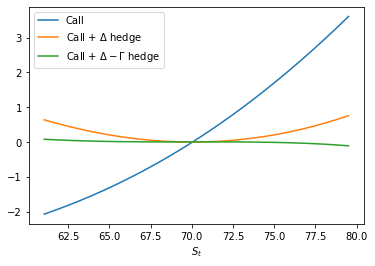

In [7]:
%matplotlib inline

# Setup two options
K1 = K
K2 = K1 + 30
option1 = mibian.BS([S0, K1, r*100, T*365], volatility = sig*100)
option2 = mibian.BS([S0, K2, r*100, T*365], volatility = sig*100)
options= [option1, option2]

# Calc their deltas, gammas and prices
deltas = [option.callDelta for option in options]
gammas = [option.gamma for option in options]
prices = [option.callPrice for option in options]

# Simulate 1D Stock prices, make an array covering their span and calculate option prices 
S_1D = gbm(S0, r, sig, dt, 1, MC)[-1]
S_1D = np.linspace(S_1D.min(), S_1D.max(), 100)
prices_1D = [np.array([mibian.BS([S, k, r*100, 364], volatility = sig*100).callPrice for S in S_1D]) for k in [K1, K2]]

# Solve the linear system for (x,y)
# AX = B
A = np.array([[1.0, deltas[1]], [0.0 , gammas[1]]]) # 1.0 and 0.0 are S(t) delta and gamma
B = np.array([[-deltas[0]], [-gammas[0]]])
x, y = np.linalg.solve(A, B) # positions in S(t) and second option

DV_1D = prices_1D[0] - prices[0]
DH_1D = (prices_1D[0] - deltas[0]*S_1D) - (prices[0] - deltas[0]*S0)*np.exp(r*dt)
DGH_1D = (prices_1D[0] + x*S_1D + y*prices_1D[1]) - (prices[0] + x*S0 + y*prices[1])*np.exp(r*dt)

plt.plot(S_1D, DV_1D, label = 'Call')
plt.plot(S_1D, DH_1D, label = 'Call + $\Delta$ hedge')
plt.plot(S_1D, DGH_1D, label = 'Call + $\Delta-\Gamma$ hedge')

plt.xlabel('$S_t$')

_ = plt.legend()

<IPython.core.display.Javascript object>


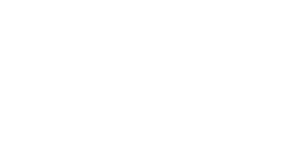

In [8]:
%matplotlib notebook

@np.vectorize
def price_surface(S_, t_):
    return mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice

@np.vectorize
def price_surface_delta_gamma_hedged(S_, t_):
    option1 = mibian.BS([S_, K1, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    option2 = mibian.BS([S_, K2, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    return option1 + x*S_ + y*option2 - (x*S0 + y*prices[1])*np.exp(r*dt)

S_lattice = np.linspace(S_1D.min(), S_1D.max(), 40)
S_lattice = np.linspace(S_1D.min(), S_1D.max(), 40)
t_lattice = np.linspace(0, dt, 20)

S, t = np.meshgrid(S_lattice, t_lattice)
V = price_surface(S, t)
Vdh = price_surface_delta_hedged(S, t)
Vdgh = price_surface_delta_gamma_hedged(S, t)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(221,projection='3d')
ax1.plot_surface(S - S0, t, V - V_0, cmap='magma')
ax1.set_xlabel('$dS_t$')
ax1.set_ylabel('$dT$')
ax1.set_zlabel('Value change')
ax1.set_title('Unhedged portfolio')
ax1.set_zlim(zmin, zmax)

ax2 = fig.add_subplot(223,projection='3d')
ax2.plot_surface(S - S0, t, Vdh - V_0, cmap='magma')
ax2.set_xlabel('$dS_t$')
ax2.set_ylabel('$dT$')
ax2.set_zlabel('Value change')
ax2.set_title('$\Delta$ hedged portfolio')
ax2.set_zlim(zmin, zmax)

ax3 = fig.add_subplot(224,projection='3d')
ax3.plot_surface(S - S0, t, Vdgh - V_0, cmap='magma')
ax3.set_xlabel('$dS_t$')
ax3.set_ylabel('$dT$')
ax3.set_zlabel('Value change')
ax3.set_title('$\Delta - \Gamma$ Hedged portfolio')
ax3.set_zlim(zmin, zmax)

plt.tight_layout()

## Dynamic hedging

Do tej pory rozważaliśmy jednodniowy przyrost. Zobaczmy jednak co dzieje się z zahedgowaną pozycją jeśli będziemy ją utrzymywać przez dłuzszy okres czasu

<IPython.core.display.Javascript object>


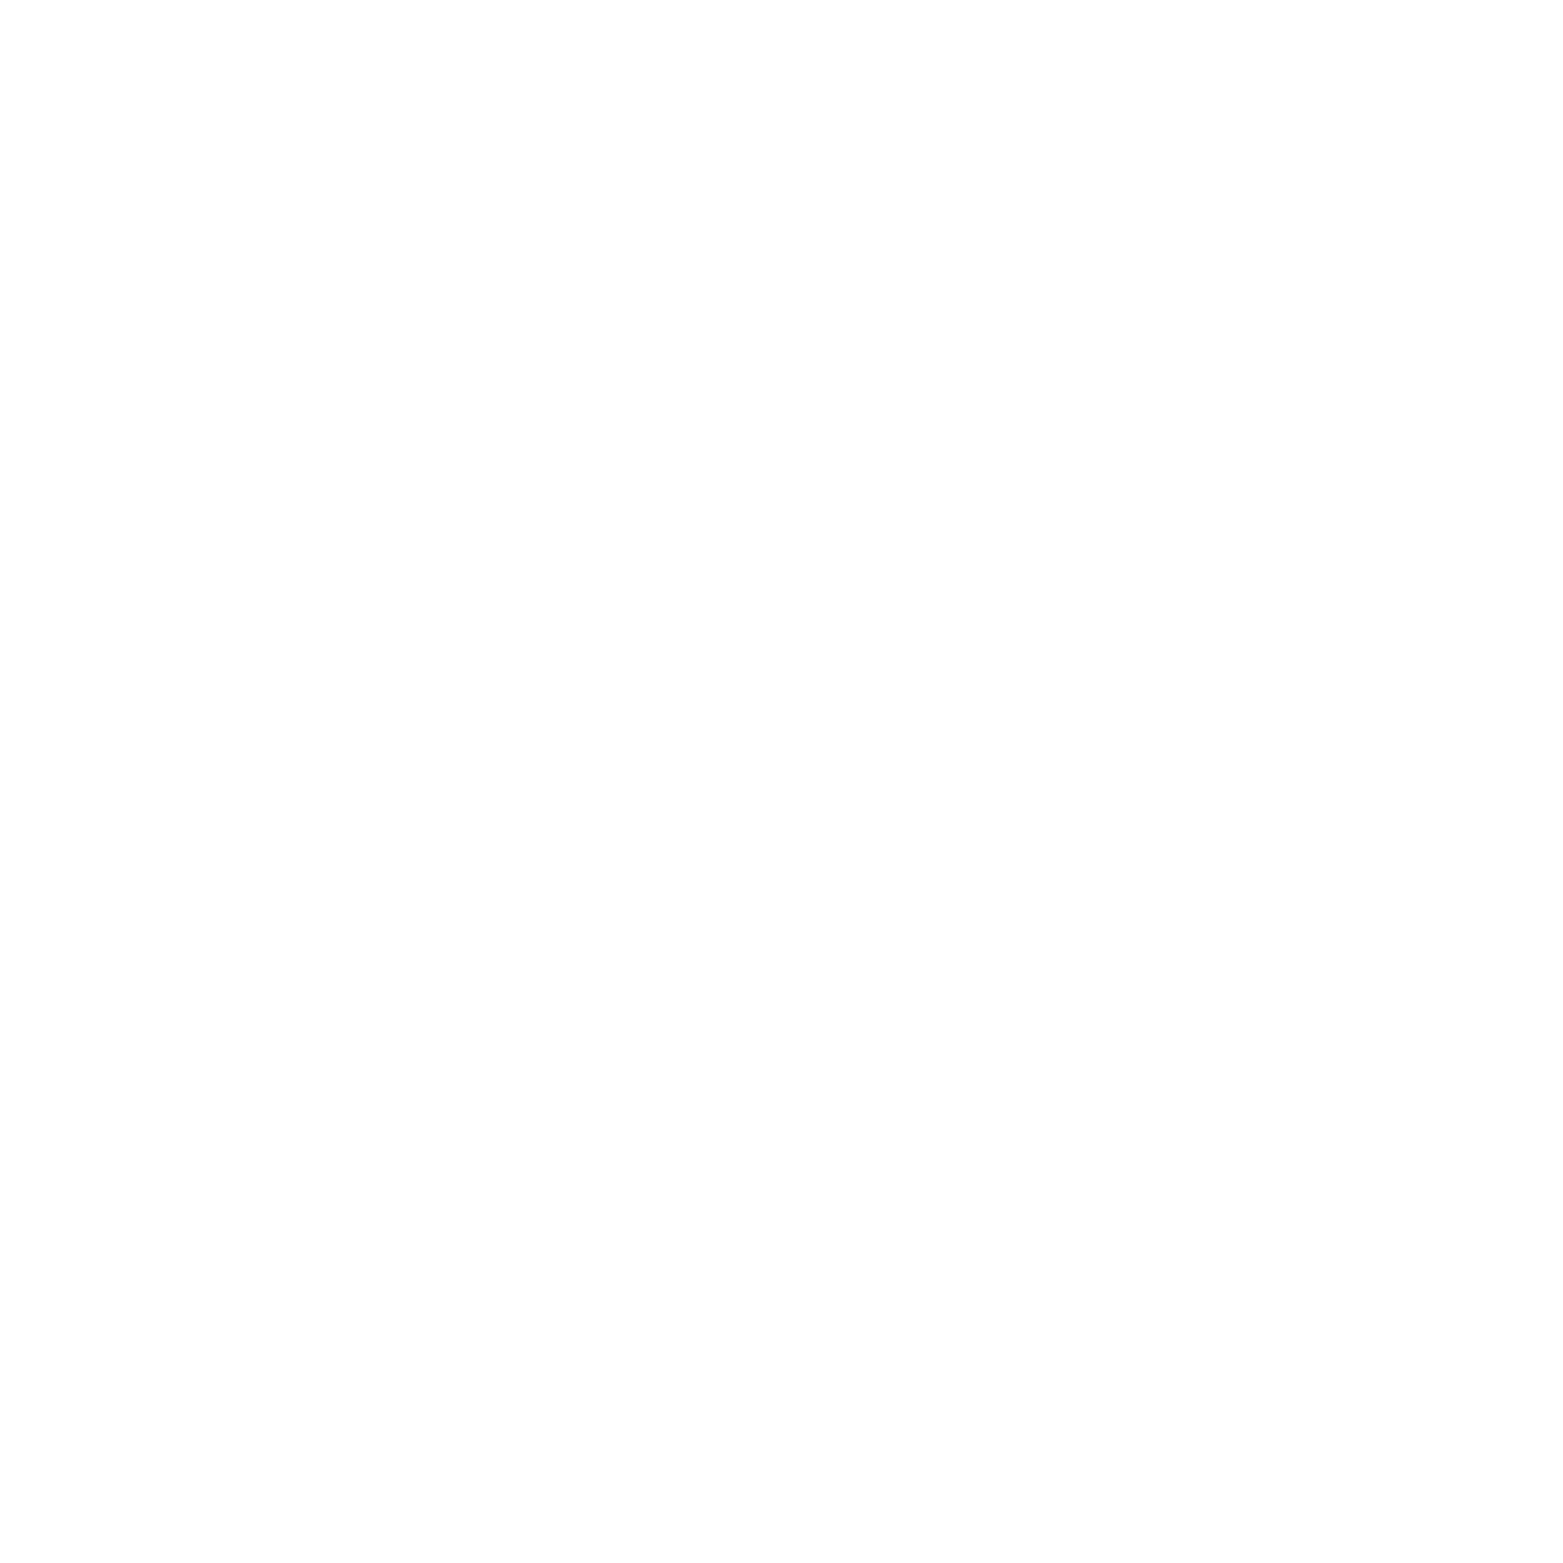

In [9]:
%matplotlib notebook

dt_longer = dt*10 

@np.vectorize
def price_surface(S_, t_):
    return mibian.BS([S_, 90, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice

@np.vectorize
def price_surface_delta_gamma_hedged(S_, t_):
    option1 = mibian.BS([S_, K1, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    option2 = mibian.BS([S_, K2, 0.05*100, (T-t_)*365], volatility = 0.3*100).callPrice
    return option1 + x*S_ + y*option2 - (x*S0 + y*prices[1])*np.exp(r*dt)

# Simulate 1 day stock trajectory
S_1D = gbm(S0, r, sig, dt_longer, 1, MC)[-1]

S_lattice = np.linspace(S_1D.min(), S_1D.max(), 40)
S_lattice = np.linspace(S_1D.min(), S_1D.max(), 40)
t_lattice = np.linspace(0, dt_longer, 20)

S, t = np.meshgrid(S_lattice, t_lattice)
V = price_surface(S, t)
Vdh = price_surface_delta_hedged(S, t)
Vdgh = price_surface_delta_gamma_hedged(S, t)

fig = plt.figure(figsize=(10, 10))

ax2 = fig.add_subplot(121,projection='3d')
ax2.plot_surface(S - S0, t, Vdh - V_0, cmap='magma')
ax2.set_xlabel('$dS_t$')
ax2.set_ylabel('$dT$')
ax2.set_zlabel('Value change')
ax2.set_title('$\Delta$ hedged portfolio')
ax2.set_zlim(zmin, zmax)

ax3 = fig.add_subplot(122,projection='3d')
ax3.plot_surface(S - S0, t, Vdgh - V_0, cmap='magma')
ax3.set_xlabel('$dS_t$')
ax3.set_ylabel('$dT$')
ax3.set_zlabel('Value change')
ax3.set_title('$\Delta - \Gamma$ Hedged portfolio')
ax3.set_zlim(zmin, zmax)

plt.tight_layout()

Rozwiązaniem może być dynamiczne rebalansowanie pozycji - np. codziennie, co kilka dni, czy co tydzień etc.
Pojawia się tu inny problem, bo im częściej rebalansujemy tym większe koszty transakcji ponosimy. W praktyce należy dobrać pewien trade-off między częstością rebalansowania, a jego kosztami. 

Żeby doczytać więcej na ten temat sprawdź:
* [Ten artykuł](https://www.efmaefm.org/0efmameetings/efma%20annual%20meetings/2005-Milan/papers/284-zakamouline_paper.pdf) bazujący na funkcji użyteczności
* [Trochę nowocześniejsze podejście...](https://arxiv.org/pdf/1802.03042.pdf) używające RNN ...
* [... i jego kontynuacja](https://arxiv.org/pdf/2109.12337.pdf) porównująca modele liniowe, ML i CNN.

My założymy dla uproszczenia, że kosztów transakcji nie ma i skupimy się na mechanice dynamicznego rebalansowania pozycji.

Będziemy wykonywać następujące kroki:
1. Zadamy parametry opcji, oraz rynku
2. Wyliczymy deltę, gammę i pozycje hedgujące portfel
3. Dohedgujemy/odhedgujemy pozycję w sposób bezkosztowy
4. Wysymulujemy "krok" instrumentu bazowego
5. Obliczymy nową wartość portfela zgodnie z 2. i 3.
6. Wrócimy do punktu 2.

In [10]:
option.__dict__

{'underlyingPrice': 70.0,
 'strikePrice': 90.0,
 'interestRate': 0.05,
 'daysToExpiration': 1.0,
 'callPrice': 3.462185079818429,
 'putPrice': 19.072833284882698,
 'callDelta': 0.3011666341231709,
 'putDelta': -0.6988333658768291,
 'callDelta2': -0.19577199232003928,
 'putDelta2': 0.7554574321806748,
 'callTheta': -0.012433286582584446,
 'putTheta': -0.0007058005270961913,
 'callRho': 0.17619479308803535,
 'putRho': -0.6799116889626073,
 'vega': 0.24381170914687644,
 'gamma': 0.016585830554209282,
 'impliedVolatility': None,
 'putCallParity': None,
 'volatility': 0.3,
 '_a_': 0.3,
 '_d1_': -0.5210480942696869,
 '_d2_': -0.821048094269687,
 'exerciceProbability': 0.20580943700600624}

In [11]:
option.strikePrice

90.0

In [62]:
def dynamic_hedging(stock_trajectory, option_to_hedge, option_for_gamma):
    
    gbm_traj = stock_trajectory
    K = option_to_hedge.strikePrice
    r = option_to_hedge.interestRate
    T1 = option_to_hedge.daysToExpiration
    sig = option_to_hedge.volatility
    
    K2 = option_for_gamma.strikePrice
    T2 = option_for_gamma.daysToExpiration
    
    t_axis = np.linspace(0, T1, len(gbm_traj))
    dt = t_axis[1] - t_axis[0]


    Vt = []
    St = []
    Ct = []
    t=[]

    Strategies = {'DeltaHedge': {"t": [],
                                 "Value": [],
                                 "Stock": [],
                                 "MM": []},
                  'DeltaGammaHedge': {"t": [],
                                      "Value": [],
                                      "Stock": [],
                                      "Option": [],
                                      "MM":[]}
                 }
    for S, t_ in zip(gbm_traj[:-1], t_axis[:-1]):
        
        option_V = mibian.BS([S, K, r*100, (T1-t_)*365], volatility = sig*100)
        option_C = mibian.BS([S, K2, r*100, (T2-t_)*365], volatility = sig*100)
        
        V = option_V.callPrice
        C = option_C.callPrice
        S = S

        if t_ == 0:
            DH = 0.0 # current value of delta hedged portfolio "hedge" part
            DGH = 0.0 # current value of delta-gamma hedged portfolio "hedge" part
        else:
            DH = Strategies['DeltaHedge']['Stock'][-1]*S + Strategies['DeltaHedge']['MM'][-1]*np.exp(r*dt)
            DGH = Strategies['DeltaGammaHedge']['Stock'][-1]*S + Strategies['DeltaGammaHedge']['Option'][-1]*C + Strategies['DeltaGammaHedge']['MM'][-1]*np.exp(r*dt)

        Strategies['DeltaHedge']['Value'].append(DH)
        Strategies['DeltaGammaHedge']['Value'].append(DGH)

        Vt.append(V)
        St.append(S)
        Ct.append(C)
        t.append(t_)

        # Greeks
        delta_V = option_V.callDelta
        delta_C = option_C.callDelta
        delta_S = 1.0

        gamma_V = option_V.gamma
        gamma_C = option_C.gamma
        gamma_S = 0.0
        #Pdb().set_trace()

        # Delta hedging
        A = np.array([[delta_S, 0], [S, 1]])
        B = np.array([[delta_V], [DH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaHedge']['MM'].append(X[1][0])

        #Delta-gamma hedging
        A = np.array([[delta_S, delta_C, 0], [gamma_S, gamma_C, 0], [S, C, 1]])
        B = np.array([[delta_V], [gamma_V], [DGH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaGammaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaGammaHedge']['Option'].append(X[1][0])
        Strategies['DeltaGammaHedge']['MM'].append(X[2][0])


    t = np.array(t).reshape(-1, 1)
    Vt = np.array(Vt).reshape(-1, 1)
    Strategies['DeltaHedge']['Value'] = np.array(Strategies['DeltaHedge']['Value']).reshape(-1, 1)
    Strategies['DeltaGammaHedge']['Value'] = np.array(Strategies['DeltaGammaHedge']['Value']).reshape(-1, 1)
    
    return t, Vt, Strategies 


S0 = 60.
r = .05
sig = .3
T = 365. # days

gbm_traj = gbm(S0 = S0, r = r, sigma = sig, T = T/365, time_steps = 252, n_paths = 1).ravel()


option_to_hedge = mibian.BS([S0, 60., r*100, T], volatility = sig*100)
option_for_gamma = mibian.BS([S0, 65., r*100, T], volatility = sig*100)

t, Vt, Strategies = dynamic_hedging(gbm_traj, option_to_hedge = option_to_hedge, option_for_gamma = option_for_gamma)

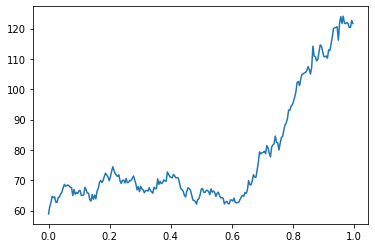

In [49]:
%matplotlib inline 
plt.plot(t, gbm_traj[1:])

<IPython.core.display.Javascript object>


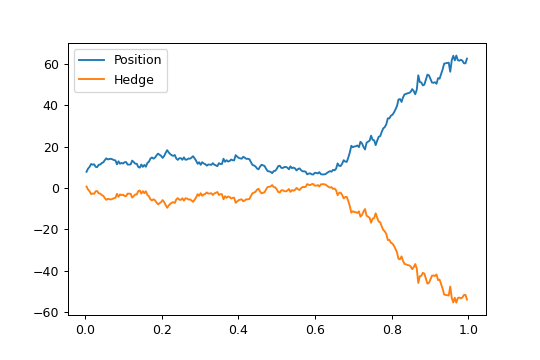

<IPython.core.display.Javascript object>


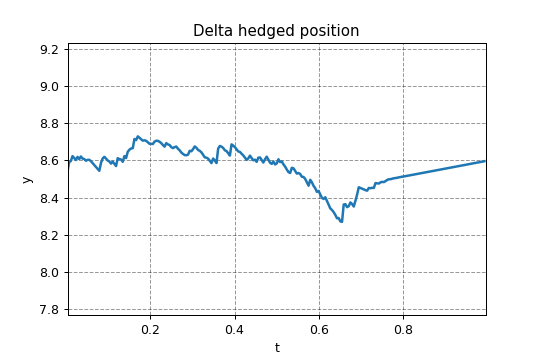

In [50]:
%matplotlib notebook
plt.plot(t[1:], Vt[1:], label = 'Position')
plt.plot(t[1:], -Strategies['DeltaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t[1:], Vt[1:] - Strategies['DeltaHedge']['Value'][1:], "Delta hedged position")

<IPython.core.display.Javascript object>


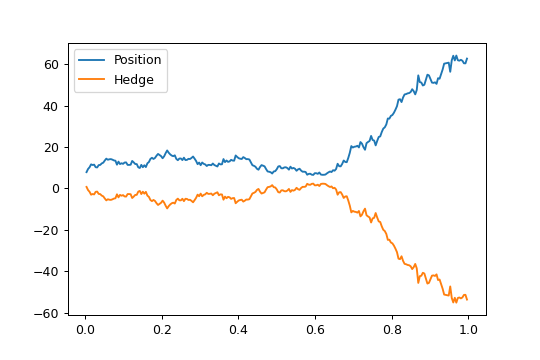

<IPython.core.display.Javascript object>


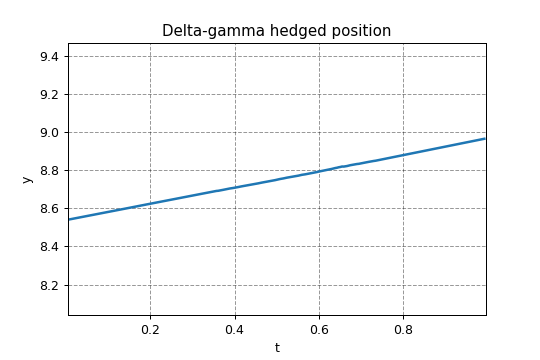

In [51]:
%matplotlib notebook
plt.plot(t[1:], Vt[1:], label = 'Position')
plt.plot(t[1:], -Strategies['DeltaGammaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t[1:], Vt[1:] - Strategies['DeltaGammaHedge']['Value'][1:], "Delta-gamma hedged position")

In [52]:
diff = (Vt[1:] - Strategies['DeltaGammaHedge']['Value'][1:])
np.log(diff[-1]/diff[0])

array([0.0487878])

# Przykład na danych rynkowych

In [53]:
ticker = "MSFT"
real_data = yf.download(ticker, start="2019-10-01", end="2020-10-01")['Open']
calibration_data = yf.download(ticker, start = "2018-10-01", end="2019-10-01")["Open"]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


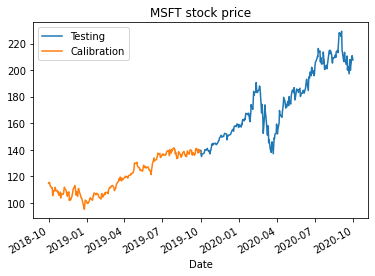

In [54]:
%matplotlib inline
real_data.plot(label="Testing")
calibration_data.plot(label="Calibration")

plt.legend()
_ = plt.title(f"{ticker} stock price")

In [63]:
S0 = real_data[0]
sig_hist = np.log(calibration_data).diff().mean()*np.sqrt(365)
t_real, Vt_real, Strategies_real = dynamic_hedging(real_data,
                                                   option_to_hedge = mibian.BS([S0, 190, r*100, 365], volatility = sig_hist*100),
                                                   option_for_gamma = mibian.BS([S0, 200, r*100, 2*365], volatility = sig_hist*100))

<IPython.core.display.Javascript object>


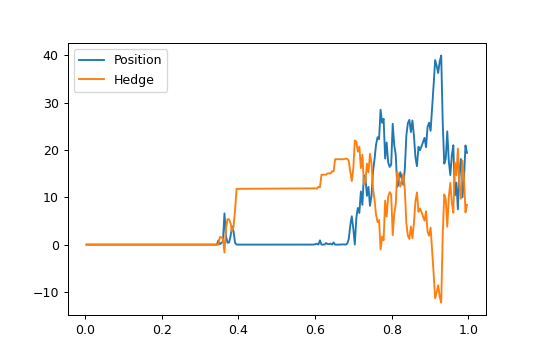

<IPython.core.display.Javascript object>


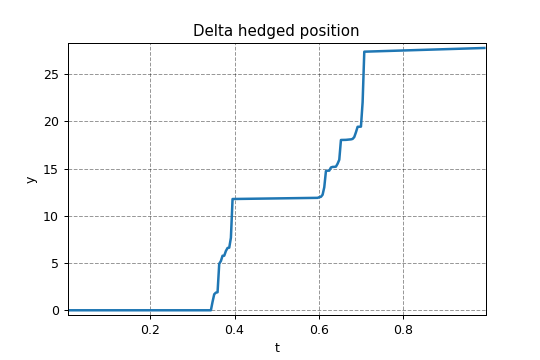

In [64]:
%matplotlib notebook
plt.plot(t_real[1:], Vt_real[1:], label = 'Position')
plt.plot(t_real[1:], -Strategies_real['DeltaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t_real[1:], Vt_real[1:] - Strategies_real['DeltaHedge']['Value'][1:], "Delta hedged position")

<IPython.core.display.Javascript object>


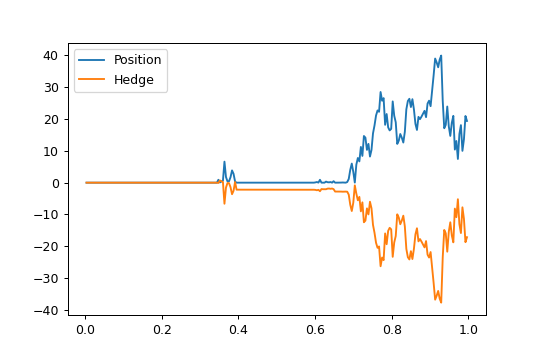

<IPython.core.display.Javascript object>


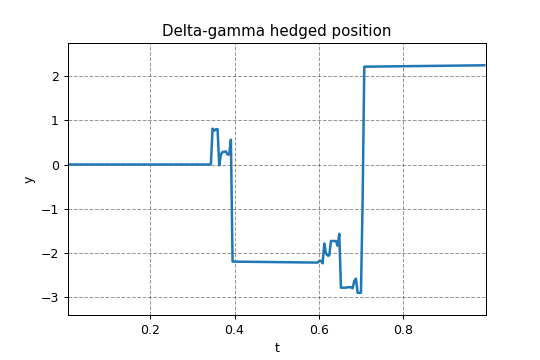

In [65]:
%matplotlib notebook
plt.plot(t_real[1:], Vt_real[1:], label = 'Position')
plt.plot(t_real[1:], -Strategies_real['DeltaGammaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t_real[1:], Vt_real[1:] - Strategies_real['DeltaGammaHedge']['Value'][1:], "Delta-gamma hedged position")

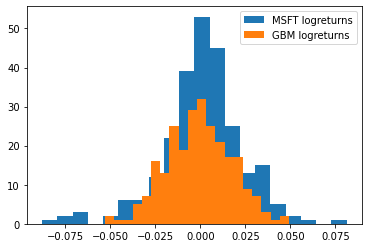

In [66]:
%matplotlib inline
real_data_np = np.array(real_data).reshape(-1, 1)
logrets_real = np.diff(np.log(real_data_np), axis = 0)
plt.hist(logrets_real, label = f'{ticker} logreturns', bins = 20)

logrets_gbm = np.diff(np.log(gbm_traj))
plt.hist(logrets_gbm, label = 'GBM logreturns', bins = 20)
plt.legend()

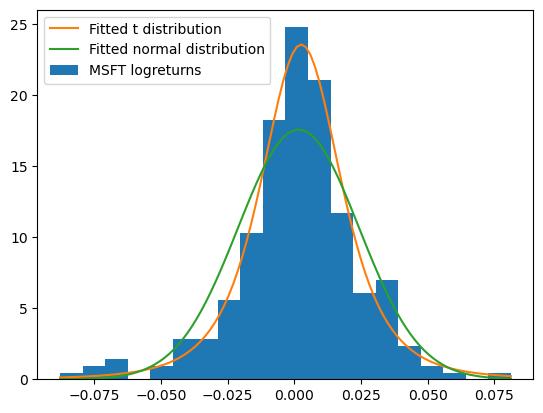

In [67]:
plt.style.use('default')
t_fitted = sc.t.fit(logrets_real)
t_fitted = sc.t(*t_fitted)

norm_fitted = sc.norm.fit(logrets_real)
norm_fitted = sc.norm(*norm_fitted)

cauchy_fitted = sc.cauchy.fit(logrets_real)
cauchy_fitted = sc.cauchy(*cauchy_fitted)

x_axis = np.linspace(logrets_real.min(), logrets_real.max(), 100)
_=plt.hist(logrets_real, label =f'{ticker} logreturns', bins = 20, density = True)
plt.plot(x_axis, t_fitted.pdf(x_axis), label = 'Fitted t distribution')
plt.plot(x_axis, norm_fitted.pdf(x_axis), label = 'Fitted normal distribution')
_= plt.legend()

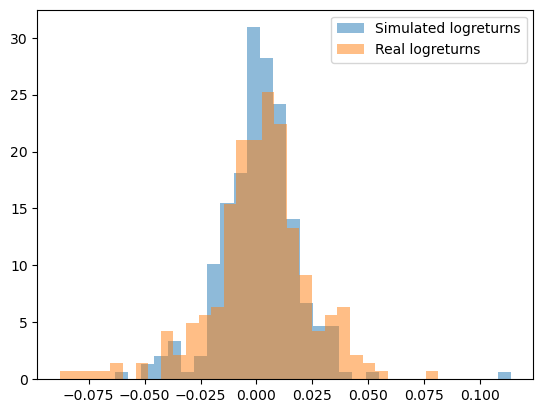

In [69]:
%matplotlib inline
plt.style.use('default')
t_params = sc.t.fit((logrets_real - logrets_real.mean())/logrets_real.std())
t_fit = sc.t(*t_params)

St = gbm(S0 = 100, r = 0.01, sigma = 0.3, T = 1, time_steps=252, n_paths = 1, random_generator = t_fit)
logrets_sim = np.diff(np.log(St), axis = 0)

x_axis = np.linspace(logrets_real.min(), logrets_real.max(), 100)
_ = plt.hist(logrets_sim, label ='Simulated logreturns', bins = 30, density = True, alpha = 0.5)
_ = plt.hist(logrets_real, label ='Real logreturns', bins = 30, density = True, alpha = 0.5)

_ = plt.legend()

In [54]:
def price_MC(stock_trajectory, strike, r, T, option_type):
    
    ST = stock_trajectory[-1, :]
    if option_type == 'CALL':
        payoff = np.maximum(ST - strike, 0).mean()
    else:
        payoff = np.maximum(strike - ST, 0).mean()
    
    return payoff*np.exp(-r*T)

def dynamic_hedging2(stock_trajectory, random_generator, option_to_hedge, option_for_gamma):
    
    gbm_traj = stock_trajectory
    option_type, K = option_to_hedge
    option_type2, K2 = option_for_gamma
    
    t_axis = np.linspace(0, T, len(gbm_traj))
    dt = t_axis[1] - t_axis[0]


    Vt = []
    St = []
    Ct = []
    t=[]

    Strategies = {'DeltaHedge': {"t": [],
                                 "Value": [],
                                 "Stock": [],
                                 "MM": []},
                  'DeltaGammaHedge': {"t": [],
                                      "Value": [],
                                      "Stock": [],
                                      "Option": [],
                                      "MM":[]}
                 }
    for ind, (S, t_) in enumerate(zip(gbm_traj[:-10], t_axis[:-10])):
        K = S*0.9
        K2 = S*1.1
        
        V = vanilla_price(S, K, option_type, r, sig, T-t_)
        C = vanilla_price(S, K2, option_type2, r, sig, T-t_)
        S = S

        if t_ == 0:
            DH = 0.0
            DGH = 0.0
        else:
            DH = Strategies['DeltaHedge']['Stock'][-1]*S + Strategies['DeltaHedge']['MM'][-1]*np.exp(r*dt)
            DGH = Strategies['DeltaGammaHedge']['Stock'][-1]*S + Strategies['DeltaGammaHedge']['Option'][-1]*C + Strategies['DeltaGammaHedge']['MM'][-1]*np.exp(r*dt)

        Strategies['DeltaHedge']['Value'].append(DH)
        Strategies['DeltaGammaHedge']['Value'].append(DGH)

        Vt.append(V)
        St.append(S)
        Ct.append(C)
        t.append(t_)
        
        epsilon = 0.000001
        S_plus = S*(1+epsilon)
        S_minus = S*(1-epsilon)
        dS = S_plus - S_minus
        
        simu_S = gbm(S0 = S, r = 0.01, sigma = 0.3, T = T-t_, time_steps=len(gbm_traj[:-10])-ind, n_paths = 200000, 
                     random_generator = random_generator)
        simu_S_plus = simu_S*(1+epsilon)
        simu_S_minus = simu_S*(1-epsilon)
        
        
        # Greeks
        delta_V = (price_MC(simu_S_plus, K, r, T, option_type) - 
                   price_MC(simu_S_minus, K, r, T, option_type))/(2*dS)
        delta_C = (price_MC(simu_S_plus, K2, r, T, option_type) -
                   price_MC(simu_S_minus, K2, r, T, option_type))/(2*dS)
        delta_S = 1.0

        
        gamma_V = (price_MC(simu_S_plus, K, r, T, option_type) - 
                   2*price_MC(simu_S, K, r, T, option_type) + 
                   price_MC(simu_S_minus, K, r, T, option_type))/(dS**2)
        gamma_C = (price_MC(simu_S_plus, K2, r, T, option_type2) - 
                   2*price_MC(simu_S, K2, r, T, option_type2) + 
                   price_MC(simu_S_minus, K2, r, T, option_type2))/(dS**2)
        gamma_S = 0.0

        print(f"S_{t_:.2f} = {S:.4f}: delta_V = {delta_V:.4f}, delta_C = {delta_C:.4f}, gamma_V = {gamma_V:.4f}, gamma_C = {gamma_C:.4f}")
        # Delta hedging
        A = np.array([[delta_S, 0], [S, 1]])
        B = np.array([[delta_V], [DH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaHedge']['MM'].append(X[1][0])

        #Delta-gamma hedging
        A = np.array([[delta_S, delta_C, 0], [gamma_S, gamma_C, 0], [S, C, 1]])
        B = np.array([[delta_V], [gamma_V], [DGH]])
        X = np.linalg.solve(A, B)

        Strategies['DeltaGammaHedge']['Stock'].append(X[0][0])
        Strategies['DeltaGammaHedge']['Option'].append(X[1][0])
        Strategies['DeltaGammaHedge']['MM'].append(X[2][0])

    t = np.array(t).reshape(-1, 1)
    Vt = np.array(Vt).reshape(-1, 1)
    Strategies['DeltaHedge']['Value'] = np.array(Strategies['DeltaHedge']['Value']).reshape(-1, 1)
    Strategies['DeltaGammaHedge']['Value'] = np.array(Strategies['DeltaGammaHedge']['Value']).reshape(-1, 1)
    
    return t, Vt, Strategies 

In [ ]:
t_real, Vt_real, Strategies_real = dynamic_hedging2(real_data, random_generator = t_fit, option_to_hedge = ('CALL', 100), option_for_gamma = ('CALL', 90))

In [ ]:
%matplotlib notebook
plt.plot(t_real[1:], Vt_real[1:], label = 'Position')
plt.plot(t_real[1:], Strategies_real['DeltaHedge']['Value'][1:], label = "Hedge")
plt.legend()

run_animation(t_real[1:], Vt_real[1:] - Strategies_real['DeltaHedge']['Value'][1:], "Delta hedged position")